[![Map Pipeline](https://github.com/YertleTurtleGit/depth-from-normals/actions/workflows/map_pipeline.yml/badge.svg)](https://github.com/YertleTurtleGit/depth-from-normals/actions/workflows/map_pipeline.yml)
[![Lint](https://github.com/YertleTurtleGit/depth-from-normals/actions/workflows/lint.yml/badge.svg)](https://github.com/YertleTurtleGit/depth-from-normals/actions/workflows/lint.yml)
<a target="_blank" href="https://colab.research.google.com/github/YertleTurtleGit/depth-from-normals/blob/main/README.ipynb">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

<!-- START doctoc generated TOC please keep comment here to allow auto update -->
<!-- END doctoc generated TOC please keep comment here to allow auto update -->

# Introduction


This algorithm utilizes the normal mapping to approximate a 3D integral by means of surface integrals of vector fields. Initially, the directional gradients of the normals are determined along the x- and y-directions. These gradients are then used to compute the integrated values by employing a cumulative sum (Riemann sum). To enhance the accuracy of the estimated values, this process is repeated multiple times with the gradient mapping rotated in different orientations, and the results are averaged.

# Quickstart

In [13]:
%pip install -qq pathlib2
import pathlib2 as pathlib

if not (
    pathlib.Path(".git").is_dir() and pathlib.Path.cwd().name == "depth-from-normals"
):
    !git clone -q https://github.com/YertleTurtleGit/depth-from-normals.git
    %cd depth-from-normals/

%pip install -qq -r requirements.txt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from height_map import (
    estimate_height_map,
)  # local file 'height_map.py' in this repository
from matplotlib import pyplot as plt
import numpy as np
from skimage import io

NORMAL_MAP_A_PATH: str = "https://raw.githubusercontent.com/YertleTurtleGit/depth-from-normals/main/normal_mapping_a.png"
NORMAL_MAP_B_PATH: str = "https://raw.githubusercontent.com/YertleTurtleGit/depth-from-normals/main/normal_mapping_b.png"
NORMAL_MAP_A_IMAGE: np.ndarray = io.imread(NORMAL_MAP_A_PATH)
NORMAL_MAP_B_IMAGE: np.ndarray = io.imread(NORMAL_MAP_B_PATH)

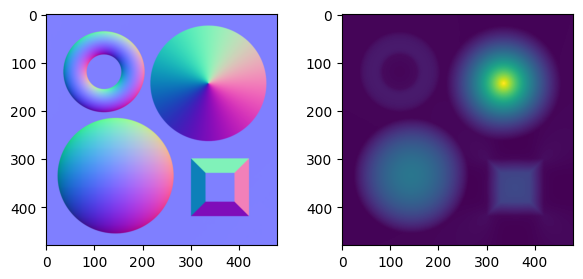

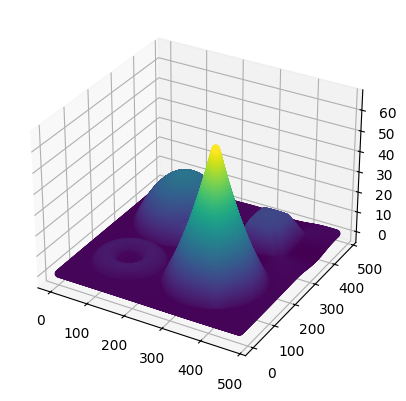

In [3]:
heights = estimate_height_map(NORMAL_MAP_A_IMAGE, raw_values=True)

figure, axes = plt.subplots(1, 2, figsize=(7, 3))
_ = axes[0].imshow(NORMAL_MAP_A_IMAGE)
_ = axes[1].imshow(heights)

x, y = np.meshgrid(range(heights.shape[1]), range(heights.shape[0]))
_, axes = plt.subplots(1, 1, subplot_kw={"projection": "3d"})
_ = axes.scatter(x, y, heights, c=heights)

# Explanation


In [4]:
import cv2 as cv
from scipy.integrate import cumulative_trapezoid, simpson
from multiprocessing.pool import ThreadPool as Pool
from multiprocessing import cpu_count
from typing import List, Tuple
from matplotlib.colors import TwoSlopeNorm

## Gradients

By deriving gradients in the x- and y-directions from the normal mapping, a mapping of angles is generated, which can be utilized to compute the directional gradients.

Given the normal vector $\vec{n} \in \mathbb{R}^{3}$ and a rotation value $r \in \mathbb{R}[0,2\pi]$, the anisotropic gradients are calculated:

$$
a_h = \arccos{\vec{n_x}}, \hspace{5px} g_l = (1 - \sin{a_h}) * sgn(a_h - \frac{\pi}{2})
$$

$$
a_v = \arccos{\vec{n_y}}, \hspace{5px} g_t = (1 - \sin{a_v}) * sgn(a_v - \frac{\pi}{2})
$$


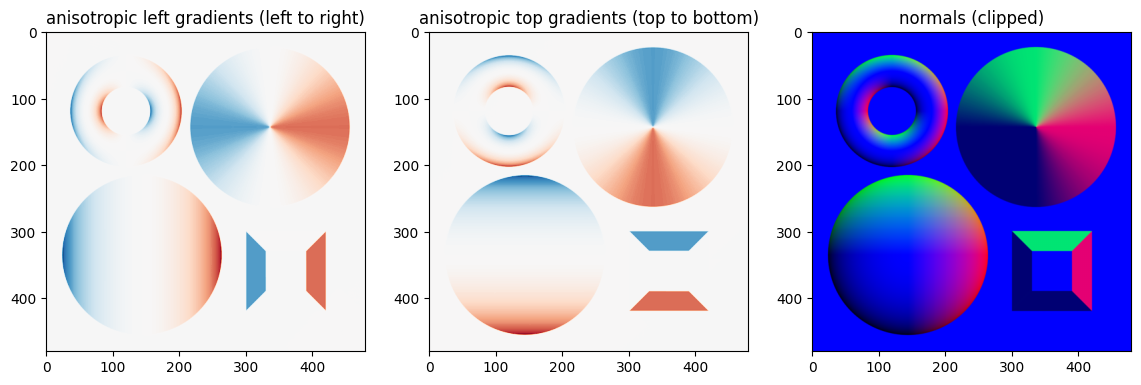

In [5]:
def calculate_gradients(normals: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    normals = normals.astype(np.float64)

    horizontal_angle_map = np.arccos(np.clip(normals[..., 0], -1, 1))
    left_gradients = np.sign(horizontal_angle_map - np.pi / 2) * (
        1 - np.sin(horizontal_angle_map)
    )

    vertical_angle_map = np.arccos(np.clip(normals[..., 1], -1, 1))
    top_gradients = -np.sign(vertical_angle_map - np.pi / 2) * (
        1 - np.sin(vertical_angle_map)
    )

    return left_gradients, top_gradients


normals = ((NORMAL_MAP_A_IMAGE[:, :, :3] / 255) - 0.5) * 2
left_gradients, top_gradients = calculate_gradients(normals)


figsize = (14, 14)
figure, axes = plt.subplots(1, 3, figsize=figsize)
axes[0].set_title("anisotropic left gradients (left to right)")
_ = axes[0].imshow(left_gradients, cmap="RdBu", norm=TwoSlopeNorm(0))
axes[1].set_title("anisotropic top gradients (top to bottom)")
_ = axes[1].imshow(top_gradients, cmap="RdBu", norm=TwoSlopeNorm(0))
axes[2].set_title("normals (clipped)")
_ = axes[2].imshow(np.clip(normals, 0, 255))

## Heights

The height values $h(x,y) \in \mathbb{R}^{2}, \ \ x,y \in \mathbb{N}^{0}$ can be obtained by performing a cumulative sum over the gradients, which eventually approaches an integral over $g(x,y)$:

$$
h(x_t,y_t) = \iint g(x,y) dydx \ \ (x_t,y_t) \approx \sum_{x_i=0}^{x_t} g(x_i,y_t)
$$

The isotropic (non-directional) heights are determined by a combination of all the anisotropic heights.


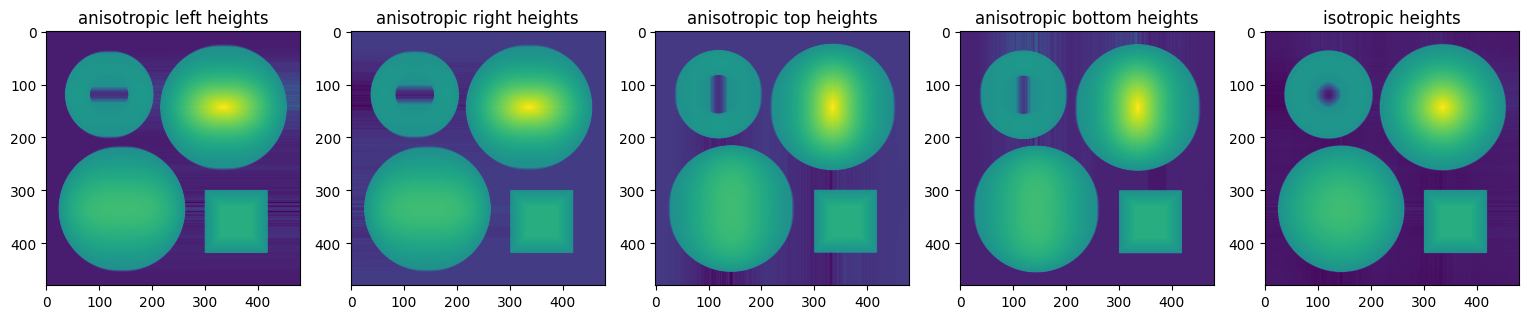

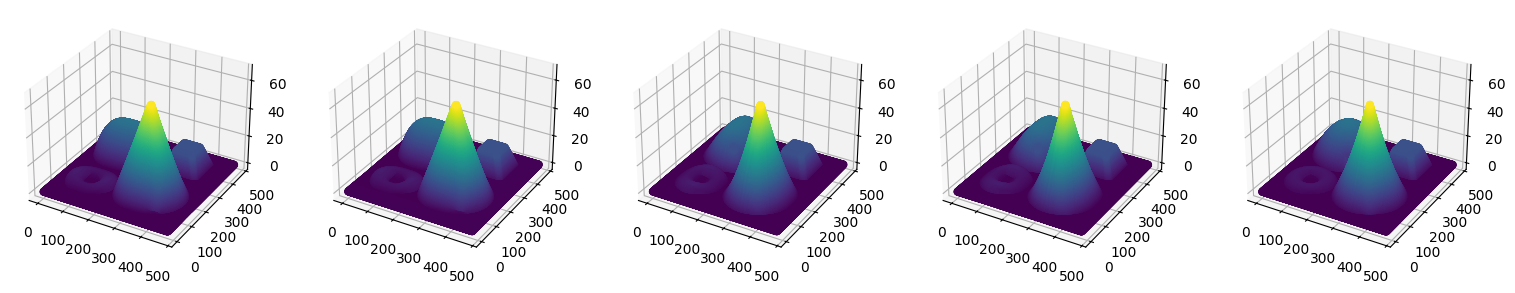

In [6]:
def integrate_gradient_field(gradient_field: np.ndarray, axis: int) -> np.ndarray:
    return np.cumsum(gradient_field, axis=axis)


def calculate_heights(
    left_gradients: np.ndarray, top_gradients: np.ndarray
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    left_heights = integrate_gradient_field(left_gradients, axis=1)
    right_heights = integrate_gradient_field(-left_gradients[:, ::-1], axis=1)[:, ::-1]
    top_heights = integrate_gradient_field(top_gradients, axis=0)
    bottom_heights = integrate_gradient_field(-top_gradients[::-1], axis=0)[::-1]

    return left_heights, right_heights, top_heights, bottom_heights


left_heights, right_heights, top_heights, bottom_heights = calculate_heights(
    left_gradients, top_gradients
)


def combine_heights(*heights: np.ndarray) -> np.ndarray:
    return np.mean(np.stack(heights, axis=0), axis=0)


isotropic_heights = combine_heights(
    left_heights, right_heights, top_heights, bottom_heights
)


def visualize_heights(heights_list: List[np.ndarray], labels: List[str]):
    if len(heights_list) == 1:
        heights = heights_list[0]
        plt.title(labels[0])
        _ = plt.imshow(heights)
        x, y = np.meshgrid(range(heights.shape[1]), range(heights.shape[0]))
        _, axes = plt.subplots(1, 1, subplot_kw={"projection": "3d"})
        _ = axes.scatter(x, y, heights, c=heights)
        return

    figure, axes = plt.subplots(1, len(heights_list), figsize=(19, 5))
    for index, heights in enumerate(heights_list):
        axes[index].set_title(labels[index])
        _ = axes[index].imshow(heights, norm=TwoSlopeNorm(0.5))

    x, y = np.meshgrid(range(left_heights.shape[0]), range(left_heights.shape[1]))
    figure, axes = plt.subplots(
        1, len(heights_list), subplot_kw={"projection": "3d"}, figsize=(19, 5)
    )
    for index, heights in enumerate(heights_list):
        _ = axes[index].scatter(x, y, heights, c=heights)


visualize_heights(
    [left_heights, right_heights, top_heights, bottom_heights, isotropic_heights],
    [
        "anisotropic left heights",
        "anisotropic right heights",
        "anisotropic top heights",
        "anisotropic bottom heights",
        "isotropic heights",
    ],
)

## Rotation

While using the cumulative sum (Riemann sum) to calculate the height map is a straightforward and efficient method, it may result in errors, particularly when the gradient mapping contains abrupt changes in direction. In order to mitigate such errors, the estimate_height_map function utilizes multiple rotated versions of the gradient mapping and computes their averages to generate the height map. This approach aids in the reduction of errors and enhances the precision of the height map estimates.

$$
h(x_t,y_t) = \sum_{r=0}^{2\pi} \sum_{x_i=0}^{x_t} g R_\theta (x_i,y_t)
$$

To refer to the height maps in polar coordinates representing the left, right, top, and bottom, it would be more appropriate to name them as 180°, 0°, 90°, and 270° height maps, respectively.


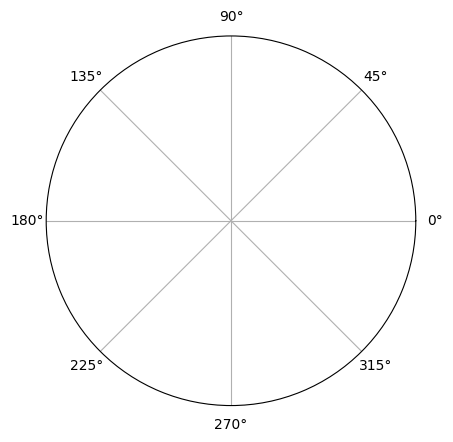

In [7]:
plt.polar()
_ = plt.yticks([])

When computing an anisotropic height map for a 225° direction, it is necessary to first rotate the normal map. However, a standard image rotation technique may lead to incorrect normal vectors, hence it is also essential to perform a corresponding rotation of the normal vectors.

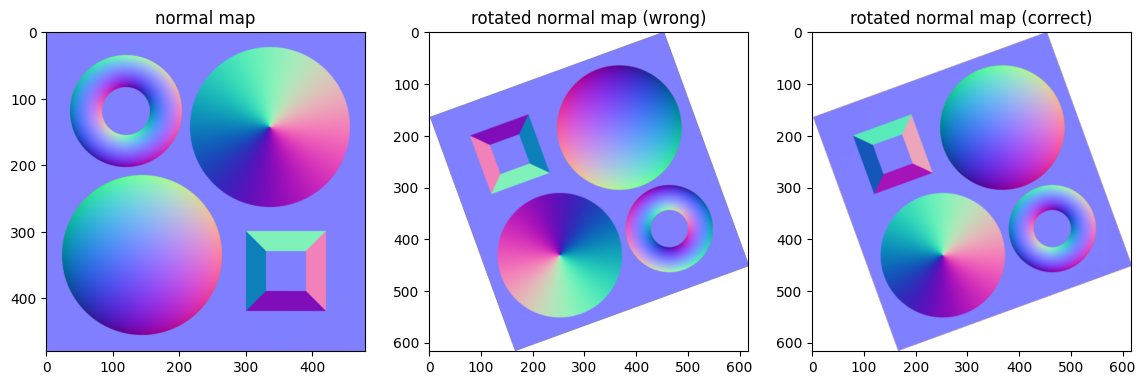

In [8]:
ANGLE = 200


def rotate(matrix: np.ndarray, angle: float) -> np.ndarray:
    h, w = matrix.shape[:2]
    center = (w / 2, h / 2)

    rotation_matrix = cv.getRotationMatrix2D(center, angle, 1.0)
    corners = cv.transform(
        np.array([[[0, 0], [w, 0], [w, h], [0, h]]]), rotation_matrix
    )[0]

    _, _, w, h = cv.boundingRect(corners)

    rotation_matrix[0, 2] += w / 2 - center[0]
    rotation_matrix[1, 2] += h / 2 - center[1]
    result = cv.warpAffine(matrix, rotation_matrix, (w, h), flags=cv.INTER_LINEAR)

    return result


rotated_normal_map_wrong = rotate(NORMAL_MAP_A_IMAGE, ANGLE)


wrong_normals = ((rotated_normal_map_wrong.astype(np.float64) / 255) - 0.5) * 2


def rotate_vector_field_normals(normals: np.ndarray, angle: float) -> np.ndarray:
    angle = np.radians(angle)
    cos_angle, sin_angle = np.cos(angle), np.sin(angle)

    return np.stack(
        [
            normals[..., 0] * cos_angle - normals[..., 1] * sin_angle,
            normals[..., 0] * sin_angle + normals[..., 1] * cos_angle,
            normals[..., 2],
            normals[..., 3],
        ],
        axis=-1,
    )


rotated_normals = rotate_vector_field_normals(wrong_normals, ANGLE)
rotated_normal_map = (((rotated_normals + 1) / 2) * 255).astype(np.uint8)

figure, axes = plt.subplots(1, 3, figsize=figsize)
axes[0].set_title("normal map")
_ = axes[0].imshow(NORMAL_MAP_A_IMAGE)
axes[1].set_title("rotated normal map (wrong)")
_ = axes[1].imshow(rotated_normal_map_wrong)
axes[2].set_title("rotated normal map (correct)")
_ = axes[2].imshow(rotated_normal_map)

In [9]:
def centered_crop(image: np.ndarray, target_resolution: Tuple[int, int]) -> np.ndarray:
    return image[
        (image.shape[0] - target_resolution[0]) // 2 : (
            image.shape[0] - target_resolution[0]
        )
        // 2
        + target_resolution[0],
        (image.shape[1] - target_resolution[1]) // 2 : (
            image.shape[1] - target_resolution[1]
        )
        // 2
        + target_resolution[1],
    ]

In [10]:
def integrate_vector_field(
    vector_field: np.ndarray,
    target_iteration_count: int,
    thread_count: int = max(cpu_count(), 1),
) -> np.ndarray:
    shape = vector_field.shape[:2]
    angles = np.linspace(0, 90, target_iteration_count, endpoint=False)

    def integrate_vector_field_angles(angles: List[float]) -> np.ndarray:
        all_combined_heights = np.zeros(shape)

        for angle in angles:
            rotated_vector_field = rotate_vector_field_normals(
                rotate(vector_field, angle), angle
            )
            rotated_vector_field[..., 0][rotated_vector_field[..., 3] == 0] = 0
            rotated_vector_field[..., 1][rotated_vector_field[..., 3] == 0] = 0
            rotated_vector_field[..., 2][rotated_vector_field[..., 3] == 0] = 0

            left_gradients, top_gradients = calculate_gradients(rotated_vector_field)
            (
                left_heights,
                right_heights,
                top_heights,
                bottom_heights,
            ) = calculate_heights(left_gradients, top_gradients)

            combined_heights = combine_heights(
                left_heights, right_heights, top_heights, bottom_heights
            )
            combined_heights = centered_crop(rotate(combined_heights, -angle), shape)
            all_combined_heights += combined_heights / len(angles)

        return all_combined_heights

    with Pool(processes=thread_count) as pool:
        heights = pool.map(
            integrate_vector_field_angles,
            np.array(
                np.array_split(angles, thread_count),
                dtype=object,
            ),
        )
        pool.close()
        pool.join()

    isotropic_height = np.zeros(shape)
    for height in heights:
        isotropic_height += height / thread_count

    return isotropic_height


def estimate_height_map(
    normal_map: np.ndarray, target_iteration_count: int = 250
) -> np.ndarray:
    if normal_map.shape[2] == 3:
        normal_map = np.pad(normal_map, ((0, 0), (0, 0), (0, 1)), constant_values=255)

    normals = ((normal_map.astype(np.float64) / 255) - 0.5) * 2
    heights = integrate_vector_field(normals, target_iteration_count)
    return heights


heights = estimate_height_map(NORMAL_MAP_B_IMAGE, 15)


figure, axes = plt.subplots(1, 4, figsize=(14, 6))

for index in range(4):
    target_iteration_count = max(1, index * 5)
    heights = estimate_height_map(NORMAL_MAP_B_IMAGE, target_iteration_count)
    x, y = np.meshgrid(range(heights.shape[0]), range(heights.shape[1]))

    axes[index].set_title(f"target iteration count: {target_iteration_count}")
    _ = axes[index].imshow(heights)

TypeError: '<' not supported between instances of 'method' and 'int'

# Discussion

## Integration

The cumulative sum method is a rudimentary approach for computing integrals. In the following, we have implemented the trapezoid and Simpson's method to provide additional options for integral computation.

In [ ]:
from enum import auto, Enum


class INTEGRATION_METHODS(Enum):
    SUM = auto()
    TRAPEZOID = auto()
    SIMSPSON = auto()


def integrate_gradient_field(gradient_field: np.ndarray, axis: int) -> np.ndarray:
    if INTEGRATION_METHOD == INTEGRATION_METHOD.SUM:
        return np.cumsum(gradient_field, axis=axis)

    if INTEGRATION_METHOD == INTEGRATION_METHOD.TRAPEZOID:
        return cumulative_trapezoid(gradient_field, axis=axis, initial=0)

    if INTEGRATION_METHOD == INTEGRATION_METHOD.SIMSPSON:
        integral = np.zeros(gradient_field.shape[:2])

        if axis == 1:
            for y in range(gradient_field.shape[0]):
                for x in range(1, gradient_field.shape[1]):
                    integral[y, x] = simpson(gradient_field[y, :x])

        elif axis == 0:
            for x in range(gradient_field.shape[1]):
                for y in range(1, gradient_field.shape[0]):
                    integral[y, x] = simpson(gradient_field[:y, x])

        return integral

    raise NotImplementedError(
        f"Integration method '{INTEGRATION_METHOD}' not implemented."
    )


target_iteration_count = 1


INTEGRATION_METHOD = INTEGRATION_METHODS.TRAPEZOID
trapezoid_heights = estimate_height_map(NORMAL_MAP_A_IMAGE, target_iteration_count)

INTEGRATION_METHOD = INTEGRATION_METHODS.SIMSPSON
simpson_heights = estimate_height_map(NORMAL_MAP_A_IMAGE, target_iteration_count)

INTEGRATION_METHOD = INTEGRATION_METHODS.SUM
sum_heights = estimate_height_map(NORMAL_MAP_A_IMAGE, target_iteration_count)

visualize_heights(
    [sum_heights, trapezoid_heights, simpson_heights], ["sum", "trapezoid", "Simpson"]
)

Although they may appear similar and effectively provide equivalent results, the Simpson method demands considerably more computational time in this implementation than the sum and trapezoid methods. This outcome can be disheartening regarding the use of polynomial approximation to enhance the resulting heights in general.

## Confidence

A straightforward technique for computing the confidence of a pixel is to modify the heights combination function to return the negative standard deviation rather than the mean.

In [ ]:
def combine_heights(*heights: np.ndarray) -> np.ndarray:
    return -np.std(np.stack(heights, axis=0), axis=0)


confidences = estimate_height_map(NORMAL_MAP_A_IMAGE)
plt.title("confidences")
plt.xlabel(f"mean: {np.mean(confidences)}")
_ = plt.imshow(confidences)
_ = plt.colorbar()